## Optimization model

$\min_{x} f(x)$  

s.t.

$l_i \leq x_i \leq u_i,    0 \leq i < n$      
    
$cl_j \leq  c_j(x) \leq cu_j, 0 \leq j < m$

**variables**: $x_0, x_1, ..., x_i, ..., x_{n-1}$

**cost**, $R^n \rightarrow R:   f(x)$  

**contraints**, $R^n \rightarrow R^m: c(x)$

### Example 1

$\min_{x} x_0^2 + x_1^2$

s.t.   
$0 \leq x_i < 5$   
$1 \leq 2x_0 - x_1$  
$3 \leq x_0^3 - x_1^5 \leq 10$

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from RVBUST.RPS import *
np.set_printoptions(precision=4, suppress=True)

#### define problem cost/constraints

In [3]:
class Prob:
    def __init__(self):
        self.var_num = 2
        self.var_bounds = [Bounds(0, 5)] * self.var_num
        self.constraint_num = 2
        self.constraint_bounds = [Bounds(1, 1e10), Bounds(3, 10)]
        self.var0 = np.array([2.5, 2.5])
    
    def GetCost(self, x: np.ndarray, var_idx: np.ndarray)->float:
        return np.square(x).sum()
    
    def GetCostJac(self, x: np.ndarray, jac: np.ndarray, accumulation: bool, var_idx: np.ndarray=np.empty(0))->bool:
        if not accumulation:
            jac[:] = 0
        jac[0] += 2 * x[0]
        jac[1] += 2*x[1]
        return True 
    
    def GetConstraints(self, x: np.ndarray, c: np.ndarray, var_idx: np.ndarray=np.empty(0))->bool:
        c[0] = 2 * x[0] - x[1]
        c[1] = x[0] ** 3 - x[1] ** 5
        return True
    
    def GetConstraintsJac(self, x: np.ndarray, jac: np.ndarray, var_idx: np.ndarray = np.empty(0))->bool:
        jac.shape = (self.constraint_num, self.var_num)
        jac[0, 0] = 2
        jac[0, 1] = -1
        jac[1, 0] = 2*x[0]**2
        jac[1, 1] = -5*x[1]**4
        return True

In [4]:
prob = Prob()

#### construct OptModel

In [5]:
model = OptModel()

#### Add VariableSet to OptModel

In [6]:
var_set = VariableSet(prob.var_num, prob.var_bounds)

In [7]:
model.SetVariableSet(var_set)

#### Add CostTerm to OptModel

In [8]:
cost = ExCost(prob.GetCost, prob.GetCostJac)

In [9]:
model.AddCostTerm(cost)

#### Add Constraints to OptModel

In [10]:
constraints = ExConstraint(prob.constraint_num, prob.constraint_bounds, prob.GetConstraints, prob.GetConstraintsJac)

In [11]:
model.AddConstraintSet(constraints)

#### Solve the model with OptSolver

In [12]:
solver = NloptSolver()

In [13]:
solver.Initialize(prob.var0, NloptAlgorithm.LD_SLSQP)

True

In [14]:
solver.Solve(model)

True

In [15]:
x_opt = model.GetVariableValue()
min_cost = model.GetCostValue(x_opt)

In [16]:
x_opt, min_cost

(array([1.4423, 0.    ]), 2.0801302574592975)

### Example 2

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from RVBUST.RPS import *
np.set_printoptions(precision=4, suppress=True)

In [19]:
x0 = np.linspace(-np.pi, np.pi, 100)
x1 = np.linspace(-np.pi, np.pi, 100)
xs = np.meshgrid(x0, x1)

In [20]:
z = np.sin(xs[0] - np.pi/2) + np.sin(xs[1] - np.pi/2)
z1 = 0.1 * np.square(xs[0]) + 0.1 * np.square(xs[1]) - 0.3
z2 = 0.07 * np.power(xs[0], 3) + 0.1 * xs[1] * xs[1]

In [21]:
z2.min(), z2.max(), z1.min(), z1.max()

(-2.170338667647504,
 3.1573998077299232,
 -0.29979860005303355,
 1.6739208802178716)

In [22]:
z.min(), z.max()

(-1.9989930847663704, 2.0)

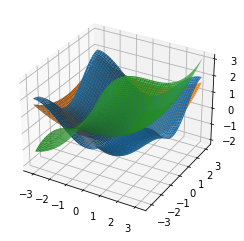

In [23]:
%matplotlib inline
# fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(projection="3d")
ax.plot_surface(xs[0], xs[1], z)
ax.plot_surface(xs[0], xs[1], z1)
ax.plot_surface(xs[0], xs[1], z2)

In [24]:
def GetCost(xs, *args):
    return np.sin(xs[0] - np.pi/2) + np.sin(xs[1] - np.pi/2)

def GetCostJac(xs, jac, *args):
    jac[0] = np.cos(xs[0] - np.pi/2)
    jac[1] = np.cos(xs[1] - np.pi/2)
    return True

In [25]:
def GetConstraintValue(xs, c, *args):
    c[0] = 0.1 * np.square(xs[0]) + 0.1 * np.square(xs[1]) - 0.3
    c[1] = 0.07 * np.power(xs[0], 3) + 0.1 * xs[1] * xs[1]
    return True

def GetConstraintJac(xs, jac, *args):
    jac.shape = (2, 2)
    jac[0] = 0.2 * xs[0], 0.2 * xs[1]
    jac[1] = 0.21 * np.square(xs[0]), 0.2 * xs[1]
    return True

In [26]:
model = OptModel()

In [27]:
model.SetVariableSet(VariableSet(2, [Bounds(-np.pi, np.pi)] * 2))

In [28]:
model.AddCostTerm(ExCost(GetCost, GetCostJac))

In [29]:
model.AddConstraintSet(ExConstraint(2, [Bounds(0.5, 1e5), Bounds(0.3, 1e5)], GetConstraintValue, GetConstraintJac))

In [30]:
solver = NloptSolver()

In [31]:
x0 = np.random.uniform(-np.pi, np.pi, 2)
solver.Initialize(x0, NloptAlgorithm.LD_SLSQP)

True

In [32]:
solver.Solve(model)

True

In [33]:
x_opt = model.GetVariableValue()
f_opt = model.GetCostValue(x_opt)

In [34]:
x_opt, f_opt

(array([-0.    , -2.8284]), -0.048636871874152665)

In [35]:
cons = model.GetConstraintSets()[0]

In [36]:
cons.IsSatisfied(x_opt)

AttributeError: 'RVBUST.RPS.PyRPS.ExConstraint' object has no attribute 'IsWithinBounds'